# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_2597421/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_2597421/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_2597421/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-11 18:43:47,304] A new study created in RDB with name: no-name-1966cc4c-ee4f-4d30-938c-4bfdb848f5cb
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:48,  3.08it/s]

current_loss: tensor(1.4437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.449866533279419
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4440985918045044
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:36, 12.74it/s]

current_loss_val:  1.4388165473937988
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4269312620162964
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4233707189559937
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.423050045967102
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.420817255973816


  0%|          | 9/2000 [00:00<02:05, 15.84it/s]

current_loss: tensor(1.4053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4190752506256104
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.419213056564331
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4191195964813232
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.419055700302124
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<01:46, 18.65it/s]

current_loss_val:  1.41902756690979
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.418925404548645
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4188623428344727
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4190672636032104
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4031, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:12, 14.99it/s]


current_loss_val:  1.4190069437026978
current_loss: tensor(1.4031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4198929071426392
current_loss: tensor(1.4030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4198777675628662
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4195873737335205
Early Stop at iteration 18 with minimal loss tensor(1.4189, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:39,  9.10it/s]

current_loss: tensor(1.3689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3766965866088867
current_loss: tensor(1.3689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.315515398979187
current_loss: tensor(1.3235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3291, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:40,  9.06it/s]

current_loss: tensor(1.3067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.299208402633667
current_loss: tensor(1.3067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2945499420166016
current_loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:22,  9.85it/s]

current_loss_val:  1.2914106845855713
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2891875505447388
current_loss: tensor(1.2878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:15, 10.21it/s]

current_loss_val:  1.2871675491333008


  0%|          | 9/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2855186462402344
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2824196815490723
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:09, 10.48it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778626680374146
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755671739578247
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.55it/s]

current_loss_val:  1.2742823362350464
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271846890449524
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271440863609314


  1%|          | 15/2000 [00:01<03:07, 10.58it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713196277618408
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708532810211182
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:06, 10.61it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270060420036316
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694236040115356
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:45,  8.79it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269128441810608
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<05:15,  6.28it/s]

current_loss_val:  1.2687194347381592
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<06:17,  5.25it/s]

current_loss_val:  1.2688031196594238
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<07:23,  4.46it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688894271850586
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<08:17,  3.97it/s]

current_loss_val:  1.268846035003662
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<09:10,  3.59it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686337232589722
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<09:40,  3.40it/s]

current_loss_val:  1.268447756767273
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<10:10,  3.23it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268274188041687
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<12:34,  2.62it/s]

current_loss_val:  1.2680048942565918
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<14:15,  2.30it/s]

current_loss_val:  1.267319679260254
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:06<15:27,  2.13it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266219973564148
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<16:16,  2.02it/s]

current_loss_val:  1.2653918266296387
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<16:40,  1.97it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639389038085938
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<15:44,  2.08it/s]

current_loss_val:  1.2624702453613281
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:07<14:33,  2.25it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620042562484741
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<13:29,  2.43it/s]

current_loss_val:  1.261633038520813
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:08<13:29,  2.43it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605000734329224
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:09<14:36,  2.24it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598918676376343
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:09<14:12,  2.30it/s]

current_loss_val:  1.2595396041870117
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:09<13:27,  2.43it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578529119491577
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:10<18:09,  1.80it/s]

current_loss_val:  1.2577240467071533
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:11<13:31,  2.41it/s]

current_loss_val:  1.2576344013214111
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571860551834106
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:11<08:41,  3.75it/s]

current_loss_val:  1.257123589515686
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571089267730713
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257100224494934


  2%|▏         | 45/2000 [00:11<06:26,  5.06it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570933103561401
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570749521255493
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:12<05:12,  6.25it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569206953048706
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568268775939941
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:12<03:58,  8.17it/s]

current_loss_val:  1.2567859888076782
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567652463912964
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256873607635498


  3%|▎         | 53/2000 [00:12<03:39,  8.85it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568981647491455
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569669485092163
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:12<07:39,  4.23it/s]


current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570909261703491
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570862770080566
Early Stop at iteration 54 with minimal loss tensor(1.2568, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:04,215] Trial 0 finished with value: -2.5135304927825928 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.308525500693744, 'penalty_decorrelation_ridge_second_difference': 27.441139119560933}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569777965545654
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571824789047241


  0%|          | 4/2000 [00:00<03:38,  9.12it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25953209400177
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260205864906311


  0%|          | 5/2000 [00:00<04:08,  8.01it/s]


current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602635622024536
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605754137039185
Early Stop at iteration 5 with minimal loss tensor(1.2570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:05,467] Trial 1 finished with value: -2.513955593109131 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.898222016858348, 'penalty_decorrelation_ridge_second_difference': 29.61847053394613}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569712400436401
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571299076080322


  0%|          | 4/2000 [00:00<03:44,  8.91it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588210105895996
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593451738357544


  0%|          | 5/2000 [00:00<04:13,  7.86it/s]


current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259369969367981
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594053745269775
Early Stop at iteration 5 with minimal loss tensor(1.2570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:06,745] Trial 2 finished with value: -2.5139424800872803 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.217923839868813, 'penalty_decorrelation_ridge_second_difference': 21.64046496467902}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 2/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570515871047974
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256875991821289
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:06, 10.73it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256840705871582
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568577527999878
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:21,  9.87it/s]

current_loss_val:  1.2568539381027222
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568520307540894
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:42,  8.96it/s]


current_loss_val:  1.2569570541381836
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257063627243042
Early Stop at iteration 7 with minimal loss tensor(1.2568, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:08,173] Trial 3 finished with value: -2.513681650161743 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.372926797870806, 'penalty_decorrelation_ridge_second_difference': 10.626501001536239}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569082975387573
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.53it/s]

current_loss_val:  1.2569584846496582
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580102682113647
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:15,  7.80it/s]

current_loss_val:  1.2578418254852295
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578046321868896
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577184438705444
Early Stop at iteration 5 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:09,458] Trial 4 finished with value: -2.5138163566589355 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.573146176135548, 'penalty_decorrelation_ridge_second_difference': 16.374567772336945}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570022344589233
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572109699249268


  0%|          | 4/2000 [00:00<03:39,  9.10it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593448162078857
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599875926971436


  0%|          | 5/2000 [00:00<04:08,  8.03it/s]


current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600480318069458
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602746486663818
Early Stop at iteration 5 with minimal loss tensor(1.2570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:10,725] Trial 5 finished with value: -2.5140044689178467 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.715888761591664, 'penalty_decorrelation_ridge_second_difference': 24.16527212349818}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256900429725647
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:29,  9.52it/s]

current_loss_val:  1.257007122039795
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583999633789062
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259133219718933


  0%|          | 5/2000 [00:00<04:02,  8.21it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587529420852661
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586262226104736
Early Stop at iteration 5 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:11,955] Trial 6 finished with value: -2.513800859451294 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.48459516859963, 'penalty_decorrelation_ridge_second_difference': 25.62085609602905}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568252086639404
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568618059158325


  0%|          | 4/2000 [00:00<03:44,  8.90it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573258876800537
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574219703674316


  0%|          | 5/2000 [00:00<04:12,  7.89it/s]


current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574018239974976
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572916746139526
Early Stop at iteration 5 with minimal loss tensor(1.2568, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:13,230] Trial 7 finished with value: -2.513650417327881 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.118767225004865, 'penalty_decorrelation_ridge_second_difference': 27.097033677490717}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568423748016357
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568954229354858


  0%|          | 4/2000 [00:00<03:43,  8.93it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576180696487427
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577751874923706


  0%|          | 5/2000 [00:00<04:13,  7.87it/s]


current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25775945186615
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25767183303833
Early Stop at iteration 5 with minimal loss tensor(1.2568, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:14,490] Trial 8 finished with value: -2.5136847496032715 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.074059926913733, 'penalty_decorrelation_ridge_second_difference': 27.040558274201242}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 2/2000 [00:00<03:08, 10.59it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572365999221802
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575256824493408
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:44,  8.91it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591160535812378
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592507600784302


  0%|          | 5/2000 [00:00<05:09,  6.44it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592490911483765


  0%|          | 5/2000 [00:00<06:03,  5.50it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594705820083618
Early Stop at iteration 5 with minimal loss tensor(1.2572, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:16,168] Trial 9 finished with value: -2.5144734382629395 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.50569723893493, 'penalty_decorrelation_ridge_second_difference': 7.634146097301452}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:58,  3.34it/s]

current_loss_val:  1.2568668127059937
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:11,  4.06it/s]

current_loss_val:  1.25692880153656
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:34,  3.88it/s]

current_loss_val:  1.2577534914016724
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:18,  3.57it/s]

current_loss_val:  1.2581510543823242
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:30,  3.50it/s]

current_loss_val:  1.2579385042190552
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578457593917847
Early Stop at iteration 5 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:18,295] Trial 10 finished with value: -2.513733148574829 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.118215835426588, 'penalty_decorrelation_ridge_second_difference': 22.808253981550827}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:36,  7.22it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256903052330017
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.45it/s]

current_loss_val:  1.2570055723190308
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583167552947998
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:11,  7.93it/s]

current_loss_val:  1.2590144872665405
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586570978164673
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585294246673584
Early Stop at iteration 5 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:19,669] Trial 11 finished with value: -2.513805627822876 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.633740428577866, 'penalty_decorrelation_ridge_second_difference': 24.031167597632674}. Best is trial 0 with value: -2.5135304927825928.
  0%|          | 1/2000 [00:00<04:56,  6.73it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568352222442627
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:51,  8.64it/s]

current_loss_val:  1.256831169128418
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257092833518982
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:53,  8.53it/s]

current_loss_val:  1.256898283958435
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256839632987976
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:31,  9.43it/s]

current_loss_val:  1.256685495376587
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565997838974
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256446123123169


  0%|          | 9/2000 [00:00<03:22,  9.82it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564555406570435
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564728260040283
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:17, 10.08it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564167976379395
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561036348342896
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:12, 10.29it/s]

current_loss_val:  1.2561895847320557
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256164312362671
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562144994735718


  1%|          | 16/2000 [00:01<03:36,  9.17it/s]


current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562758922576904
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562719583511353
Early Stop at iteration 16 with minimal loss tensor(1.2561, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:22,138] Trial 12 finished with value: -2.51220703125 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.743590288739232, 'penalty_decorrelation_ridge_second_difference': 17.120379488726964}. Best is trial 12 with value: -2.51220703125.
  0%|          | 1/2000 [00:00<04:20,  7.68it/s]

current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568795680999756
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569588422775269


  0%|          | 3/2000 [00:00<03:27,  9.62it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580078840255737
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258527159690857
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:04,  8.17it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582573890686035
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25814950466156
Early Stop at iteration 5 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:23,555] Trial 13 finished with value: -2.513759136199951 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.208344811884196, 'penalty_decorrelation_ridge_second_difference': 23.91680599232792}. Best is trial 12 with value: -2.51220703125.
  0%|          | 2/2000 [00:00<03:09, 10.52it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571873664855957
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578630447387695
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582790851593018
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586289644241333
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:03,  8.18it/s]


current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590386867523193
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593716382980347
Early Stop at iteration 5 with minimal loss tensor(1.2572, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:24,844] Trial 14 finished with value: -2.5143744945526123 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.166542628253502, 'penalty_decorrelation_ridge_second_difference': 0.6339251329515506}. Best is trial 12 with value: -2.51220703125.
  0%|          | 1/2000 [00:00<04:53,  6.80it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568098306655884
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:12,  7.90it/s]

current_loss_val:  1.2567501068115234


  0%|          | 3/2000 [00:00<07:01,  4.74it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565563917160034
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561309337615967
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:53,  6.81it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255961537361145
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560065984725952
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:43,  8.89it/s]

current_loss_val:  1.2560198307037354
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560250759124756
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559475898742676


  1%|          | 11/2000 [00:01<03:31,  9.42it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255814790725708
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558364868164062
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558625936508179
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557852268218994
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:20,  9.92it/s]

current_loss_val:  1.2556116580963135
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255589485168457
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554572820663452


  1%|          | 17/2000 [00:01<03:18,  9.97it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552757263183594
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:26,  9.58it/s]

current_loss_val:  1.2551238536834717
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551155090332031
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550605535507202


  1%|          | 21/2000 [00:02<03:21,  9.81it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552410364151
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551027536392212
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:19,  9.91it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550686597824097
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255059838294983
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:14, 10.15it/s]

current_loss_val:  1.2551040649414062
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549782991409302
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549498081207275


  1%|▏         | 29/2000 [00:03<03:11, 10.28it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548816204071045
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254817008972168
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:10, 10.32it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548396587371826
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548426389694214
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:10, 10.32it/s]

current_loss_val:  1.2547571659088135
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545067071914673
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544878721237183


  2%|▏         | 35/2000 [00:03<03:10, 10.34it/s]

current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254378318786621
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542693614959717
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:21,  9.76it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542558908462524
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541303634643555
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:17,  9.92it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541499137878418
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541650533676147
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:13, 10.12it/s]

current_loss_val:  1.254138708114624
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541247606277466
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:21,  9.70it/s]

current_loss_val:  1.2541065216064453
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541519403457642
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541477680206299


  2%|▏         | 46/2000 [00:04<03:16,  9.95it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254172682762146
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254168152809143
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:28,  9.37it/s]


current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542357444763184
Early Stop at iteration 47 with minimal loss tensor(1.2541, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:30,533] Trial 15 finished with value: -2.5082130432128906 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2915895181419801, 'penalty_decorrelation_ridge_second_difference': 16.717567300046007}. Best is trial 15 with value: -2.5082130432128906.
  0%|          | 1/2000 [00:00<08:58,  3.71it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568906545639038
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:45,  3.41it/s]

current_loss_val:  1.2568426132202148
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564829587936401


  0%|          | 3/2000 [00:00<11:23,  2.92it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:56,  3.04it/s]

current_loss_val:  1.2564243078231812
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:15,  2.95it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256437063217163
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<13:28,  2.47it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564375400543213
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<13:23,  2.48it/s]

current_loss_val:  1.2565093040466309
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<12:31,  2.65it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567024230957031
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<14:34,  2.28it/s]

current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566863298416138
Early Stop at iteration 8 with minimal loss tensor(1.2564, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:34,971] Trial 16 finished with value: -2.512848377227783 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3200110840578584, 'penalty_decorrelation_ridge_second_difference': 2.066335403312568}. Best is trial 15 with value: -2.5082130432128906.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<17:58,  1.85it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568086385726929
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<13:30,  2.46it/s]

current_loss_val:  1.2567594051361084
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:49,  2.82it/s]

current_loss_val:  1.256607174873352
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<14:06,  2.36it/s]

current_loss_val:  1.2560862302780151
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<14:32,  2.29it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561382055282593
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<15:00,  2.21it/s]

current_loss_val:  1.25607168674469
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:03<15:06,  2.20it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560464143753052


  0%|          | 8/2000 [00:03<13:59,  2.37it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256068468093872


  0%|          | 10/2000 [00:03<08:51,  3.75it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560032606124878
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558355331420898
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<07:28,  4.44it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558279037475586
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558106184005737
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<05:07,  6.46it/s]

current_loss_val:  1.255751371383667
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556489706039429
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556439638137817


  1%|          | 16/2000 [00:04<04:19,  7.64it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556514739990234
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556401491165161
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<03:55,  8.41it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556036710739136
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555841207504272
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:04<03:30,  9.39it/s]

current_loss_val:  1.2555829286575317
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555781602859497
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555174827575684


  1%|          | 24/2000 [00:04<03:23,  9.73it/s]

current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553181648254395
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552038431167603
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<03:19,  9.92it/s]

current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255082607269287
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550417184829712
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<03:16, 10.04it/s]

current_loss_val:  1.2549021244049072
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549892663955688
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:05<03:23,  9.67it/s]

current_loss_val:  1.2549277544021606
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549208402633667
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:05<06:07,  5.35it/s]

current_loss_val:  1.255319595336914
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254945158958435
Early Stop at iteration 31 with minimal loss tensor(1.2549, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:41,401] Trial 17 finished with value: -2.5098040103912354 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7033435613299257, 'penalty_decorrelation_ridge_second_difference': 17.25469996411364}. Best is trial 15 with value: -2.5082130432128906.
  0%|          | 2/2000 [00:00<03:06, 10.72it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569153308868408
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256714940071106
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:09, 10.55it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566336393356323
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565683126449585
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:28,  9.58it/s]

current_loss_val:  1.2562462091445923
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559634447097778
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:22,  9.84it/s]

current_loss_val:  1.2560324668884277
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559809684753418
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558858394622803


  0%|          | 10/2000 [00:00<03:18, 10.01it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558602094650269
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255741834640503
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.11it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557573318481445
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556670904159546
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:13, 10.26it/s]

current_loss_val:  1.255613088607788
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559555768966675
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556565999984741


  1%|          | 18/2000 [00:01<03:11, 10.35it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556023597717285
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553578615188599
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:11, 10.35it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255466103553772
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550901174545288
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:11, 10.32it/s]

current_loss_val:  1.2550814151763916
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255191445350647
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255030632019043


  1%|          | 24/2000 [00:02<03:12, 10.29it/s]

current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549371719360352
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547926902770996
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:11, 10.29it/s]

current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254639744758606
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546746730804443
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:09, 10.37it/s]

current_loss_val:  1.2544995546340942
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545032501220703
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254676103591919


  2%|▏         | 32/2000 [00:03<03:08, 10.44it/s]

current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254581093788147
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545801401138306
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:17,  9.94it/s]


current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545686960220337
Early Stop at iteration 32 with minimal loss tensor(1.2545, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:45,349] Trial 18 finished with value: -2.5089988708496094 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.10233258700775977, 'penalty_decorrelation_ridge_second_difference': 13.488705001990903}. Best is trial 15 with value: -2.5082130432128906.
  0%|          | 2/2000 [00:00<03:42,  8.99it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569172382354736
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566949129104614


  0%|          | 4/2000 [00:00<03:31,  9.45it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565351724624634
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564024925231934
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560782432556152
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2560738325119019
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559651136398315
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558194398880005


  0%|          | 10/2000 [00:01<03:20,  9.92it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557016611099243
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255741000175476
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:18, 10.02it/s]

current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555937767028809
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255433440208435
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:16, 10.08it/s]

current_loss_val:  1.255295753479004
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551276683807373
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552210092544556


  1%|          | 16/2000 [00:01<03:13, 10.25it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551640272140503
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552258968353271
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255103349685669
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552123069763184
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:12, 10.27it/s]

current_loss_val:  1.2551730871200562
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551164627075195
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551562786102295


  1%|          | 24/2000 [00:02<03:11, 10.30it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550137042999268
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549809217453003
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:12, 10.26it/s]

current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549636363983154
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548179626464844
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:13, 10.19it/s]

current_loss_val:  1.254767656326294
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545809745788574
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254624366760254


  2%|▏         | 30/2000 [00:02<03:12, 10.22it/s]

current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545335292816162
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543367147445679
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:11, 10.29it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254294991493225
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541286945343018
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:11, 10.28it/s]

current_loss_val:  1.2541426420211792
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541645765304565
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254108190536499


  2%|▏         | 38/2000 [00:03<03:09, 10.37it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541311979293823
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541581392288208
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:19,  9.83it/s]

current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541325092315674
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540674209594727
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:20,  9.79it/s]

current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540606260299683
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540318965911865
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:13, 10.13it/s]

current_loss_val:  1.2539117336273193
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539271116256714
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:11, 10.20it/s]

current_loss_val:  1.2538866996765137
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538398504257202
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253836750984192


  2%|▏         | 49/2000 [00:04<03:09, 10.29it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253833293914795
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538225650787354
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:09, 10.28it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539142370224
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25386381149292
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:05<03:11, 10.18it/s]

current_loss_val:  1.2538546323776245
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253860354423523
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:05<03:18,  9.79it/s]


current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538840770721436
Early Stop at iteration 53 with minimal loss tensor(1.2538, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:51,408] Trial 19 finished with value: -2.5076451301574707 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9946775205790774, 'penalty_decorrelation_ridge_second_difference': 9.14222870332662}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570760250091553
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569870948791504
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570399045944214
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577320337295532
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:46,  8.81it/s]

current_loss_val:  1.2573450803756714
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573014497756958
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570945024490356
Early Stop at iteration 6 with minimal loss tensor(1.2570, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:52,942] Trial 20 finished with value: -2.513974189758301 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.689273997820433, 'penalty_decorrelation_ridge_second_difference': 6.1459219694942195}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 2/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569442987442017
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567410469055176


  0%|          | 3/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566531896591187
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565793991088867
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:36,  9.20it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256425380706787
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561503648757935
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561284303665161
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561098337173462
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:24,  9.74it/s]

current_loss_val:  1.2559237480163574
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558921575546265
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557775974273682


  1%|          | 12/2000 [00:01<03:32,  9.36it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255595326423645
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:25,  9.65it/s]

current_loss_val:  1.2555371522903442
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552883625030518
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554283142089844


  1%|          | 16/2000 [00:01<03:21,  9.84it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550421953201294
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548115253448486
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548515796661377
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545112371444702
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:15, 10.12it/s]

current_loss_val:  1.2544872760772705
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546716928482056
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254260778427124


  1%|          | 24/2000 [00:02<03:13, 10.24it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542591094970703
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542190551757812
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542954683303833
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542502880096436
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:17,  9.99it/s]

current_loss_val:  1.254291296005249
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543601989746094
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:27,  9.50it/s]


current_loss_val:  1.254313349723816
Early Stop at iteration 28 with minimal loss tensor(1.2542, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:44:56,487] Trial 21 finished with value: -2.5084378719329834 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5083714292260955, 'penalty_decorrelation_ridge_second_difference': 10.90453499446821}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 2/2000 [00:00<03:10, 10.46it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569355964660645
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567280530929565
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566006183624268
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564524412155151
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.26it/s]

current_loss_val:  1.25618314743042
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558902502059937
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559319734573364


  0%|          | 8/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559722661972046
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559984922409058
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:33,  9.33it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559010982513428
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559144496917725
Early Stop at iteration 10 with minimal loss tensor(1.2559, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:44:58,209] Trial 22 finished with value: -2.511780261993408 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.386203594363492, 'penalty_decorrelation_ridge_second_difference': 8.312007494635138}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 2/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570019960403442
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569154500961304
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568155527114868
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568391561508179
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:13, 10.32it/s]

current_loss_val:  1.256606936454773
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566018104553223
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566258907318115


  0%|          | 8/2000 [00:00<03:16, 10.13it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565996646881104
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:29,  9.51it/s]

current_loss_val:  1.256476640701294
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564473152160645
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563352584838867


  1%|          | 12/2000 [00:01<03:24,  9.74it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564170360565186
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563623189926147
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:31,  9.38it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560774087905884
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:42,  8.94it/s]

current_loss_val:  1.2558984756469727
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255668044090271
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:51,  8.55it/s]

current_loss_val:  1.255713939666748
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552696466445923
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:48,  8.67it/s]

current_loss_val:  1.2552011013031006
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551137208938599
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:38,  9.05it/s]

current_loss_val:  1.2551251649856567
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255164384841919
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255040168762207


  1%|          | 24/2000 [00:02<03:27,  9.54it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551108598709106
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:36,  9.11it/s]

current_loss_val:  1.2550230026245117
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548115253448486
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546827793121338


  1%|▏         | 28/2000 [00:03<03:35,  9.14it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548646926879883
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:23,  9.67it/s]

current_loss_val:  1.2548882961273193
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550371885299683
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554328441619873


  2%|▏         | 31/2000 [00:03<03:36,  9.08it/s]


current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552133798599243
Early Stop at iteration 31 with minimal loss tensor(1.2547, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:45:02,416] Trial 23 finished with value: -2.5093653202056885 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.724724908085427, 'penalty_decorrelation_ridge_second_difference': 2.724857262989012}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:16,  7.80it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567890882492065
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:55,  8.48it/s]

current_loss_val:  1.2567962408065796
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566596269607544
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565838098526


  0%|          | 5/2000 [00:00<03:30,  9.46it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564820051193237
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563512325286865
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563087940216064
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562336921691895
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.90it/s]

current_loss_val:  1.2559733390808105
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559231519699097
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558863162994385


  1%|          | 12/2000 [00:01<03:17, 10.08it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557965517044067
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557432651519775
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:16, 10.10it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556421756744385
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553832530975342
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.21it/s]

current_loss_val:  1.2553616762161255
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553480863571167
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553244829177856
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553247213363647


  1%|          | 21/2000 [00:02<04:04,  8.08it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553126811981201
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552790641784668
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:49,  8.63it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255088448524475
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550727128982544
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:33,  9.25it/s]

current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550593614578247
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255042314529419
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<04:42,  6.98it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550395727157593
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:54,  8.41it/s]

current_loss_val:  1.2550629377365112
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550342082977295
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550206184387207


  2%|▏         | 30/2000 [00:03<03:52,  8.49it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549563646316528
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:44,  8.76it/s]

current_loss_val:  1.2549099922180176
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549084424972534
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254911184310913


  2%|▏         | 34/2000 [00:03<03:26,  9.53it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549046277999878
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:31,  9.28it/s]

current_loss_val:  1.2548377513885498
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548233270645142
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254794955253601


  2%|▏         | 39/2000 [00:04<03:25,  9.54it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546603679656982
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546910047531128


  2%|▏         | 41/2000 [00:04<03:18,  9.87it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544925212860107
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544515132904053
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:16,  9.98it/s]

current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544028759002686
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543797492980957
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:14, 10.05it/s]

current_loss_val:  1.2543303966522217
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25432550907135
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254319429397583


  2%|▏         | 47/2000 [00:05<03:14, 10.06it/s]

current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541894912719727
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:24,  9.55it/s]

current_loss_val:  1.2541897296905518
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541780471801758
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540751695632935


  3%|▎         | 52/2000 [00:05<03:19,  9.74it/s]

current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540713548660278
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540698051452637


  3%|▎         | 53/2000 [00:05<03:18,  9.79it/s]

current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540699243545532
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254078984260559
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<03:16,  9.92it/s]

current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541252374649048
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541109323501587
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:06<03:33,  9.11it/s]


current_loss_val:  1.2541009187698364
Early Stop at iteration 56 with minimal loss tensor(1.2541, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:45:09,355] Trial 24 finished with value: -2.5081393718719482 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.15178367674104631, 'penalty_decorrelation_ridge_second_difference': 26.37974302019198}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:28,  7.45it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567981481552124
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:55,  8.49it/s]

current_loss_val:  1.2568086385726929
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567541599273682
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566851377487183


  0%|          | 5/2000 [00:00<03:32,  9.40it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566243410110474
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564035654067993
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:24,  9.74it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563536167144775
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562966346740723
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560821771621704
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255995273590088
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:24,  9.74it/s]

current_loss_val:  1.2559165954589844
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556263208389282
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554079294204712


  1%|          | 14/2000 [00:01<03:18, 10.00it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553200721740723
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550137042999268
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:33,  9.31it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549015283584595
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548389434814453


  1%|          | 18/2000 [00:01<03:33,  9.27it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546820640563965
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:27,  9.52it/s]

current_loss_val:  1.2545740604400635
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544512748718262
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540283203125


  1%|          | 23/2000 [00:02<03:20,  9.87it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541382312774658
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540359497070312
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:21,  9.82it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253995656967163
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540078163146973
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:18,  9.94it/s]

current_loss_val:  1.2542612552642822
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541040182113647
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540818452835083


  1%|▏         | 28/2000 [00:03<03:32,  9.26it/s]


current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540581226348877
Early Stop at iteration 28 with minimal loss tensor(1.2540, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-11 18:45:13,013] Trial 25 finished with value: -2.507991313934326 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.3960856674821094, 'penalty_decorrelation_ridge_second_difference': 24.076412516369825}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567914724349976
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:56,  8.43it/s]

current_loss_val:  1.2567737102508545
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566558122634888
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256559133529663


  0%|          | 5/2000 [00:00<03:30,  9.49it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564908266067505
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562446594238281
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561784982681274
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560086250305176
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:20,  9.94it/s]

current_loss_val:  1.255832552909851
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559045553207397
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558021545410156


  1%|          | 12/2000 [00:01<03:15, 10.15it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25574791431427
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255712628364563
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:12, 10.29it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557642459869385
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255759358406067
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:32,  9.34it/s]

current_loss_val:  1.255761981010437
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557612657546997
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557332515716553
Early Stop at iteration 17 with minimal loss tensor(1.2557, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:45:15,512] Trial 26 finished with value: -2.511425018310547 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5595146795084945, 'penalty_decorrelation_ridge_second_difference': 25.155974482860163}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567908763885498
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:54,  8.52it/s]

current_loss_val:  1.2567894458770752
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256690263748169
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566018104553223


  0%|          | 5/2000 [00:00<03:31,  9.41it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565370798110962
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:37,  9.17it/s]

current_loss_val:  1.256282091140747
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256226658821106
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256079912185669


  0%|          | 9/2000 [00:01<03:40,  9.05it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559000253677368
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:30,  9.43it/s]

current_loss_val:  1.255878210067749
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558361291885376
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556447982788086


  1%|          | 13/2000 [00:01<03:25,  9.65it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553703784942627
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552965879440308
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552531957626343
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551807165145874
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:16, 10.08it/s]

current_loss_val:  1.2551277875900269
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550582885742188
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550079822540283


  1%|          | 20/2000 [00:02<03:15, 10.12it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548996210098267
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548562288284302
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:14, 10.15it/s]

current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547917366027832
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547341585159302
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:12, 10.24it/s]

current_loss_val:  1.2547171115875244
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547521591186523
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:23,  9.71it/s]

current_loss_val:  1.2547407150268555
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254693865776062
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254759430885315


  2%|▏         | 30/2000 [00:03<03:17,  9.98it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547155618667603
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254685878753662
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:25,  9.55it/s]

current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546478509902954
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546418905258179
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:25,  9.55it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546274662017822
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546064853668213
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:19,  9.82it/s]

current_loss_val:  1.254616141319275
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546006441116333
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254601240158081


  2%|▏         | 38/2000 [00:03<03:14, 10.08it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546019554138184
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254544973373413
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:13, 10.13it/s]

current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545437812805176
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545396089553833
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:11, 10.19it/s]

current_loss_val:  1.2545205354690552
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543314695358276
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543610334396362


  2%|▏         | 46/2000 [00:04<03:09, 10.29it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254371166229248
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254374384880066
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:20,  9.73it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543383836746216
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543185949325562
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:30,  9.25it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254286289215088
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542630434036255
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:23,  9.58it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542591094970703
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542619705200195
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:33,  9.11it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254279613494873
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542811632156372
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<03:25,  9.47it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542710304260254
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542670965194702
Early Stop at iteration 55 with minimal loss tensor(1.2543, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:45:22,043] Trial 27 finished with value: -2.5085179805755615 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6823778472125823, 'penalty_decorrelation_ridge_second_difference': 26.252224668261555}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568269968032837
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568414211273193


  0%|          | 3/2000 [00:00<03:29,  9.55it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571042776107788
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:17,  7.76it/s]

current_loss_val:  1.2570860385894775
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570408582687378
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568747997283936
Early Stop at iteration 5 with minimal loss tensor(1.2568, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:45:23,343] Trial 28 finished with value: -2.5136537551879883 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.533499979797803, 'penalty_decorrelation_ridge_second_difference': 20.657658779604034}. Best is trial 19 with value: -2.5076451301574707.
  0%|          | 1/2000 [00:00<04:22,  7.60it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567882537841797
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:54,  8.52it/s]

current_loss_val:  1.2568211555480957
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567671537399292
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566814422607422


  0%|          | 5/2000 [00:00<03:31,  9.42it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566213607788086
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563713788986206
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256329894065857
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562932968139648
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:16, 10.10it/s]

current_loss_val:  1.2559531927108765
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559813261032104
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255973219871521


  1%|          | 13/2000 [00:01<03:14, 10.23it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255947232246399
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558872699737549
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255813479423523
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255774736404419
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:14, 10.21it/s]

current_loss_val:  1.255784034729004
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255831003189087
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558716535568237


  1%|          | 19/2000 [00:01<03:13, 10.22it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558177709579468
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255771279335022
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255683422088623
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556384801864624
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:12, 10.27it/s]

current_loss_val:  1.2556177377700806
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555679082870483
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:23,  9.72it/s]

current_loss_val:  1.255548119544983
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555598020553589
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556670904159546


  1%|▏         | 28/2000 [00:02<03:17,  9.97it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556426525115967
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555946111679077
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:26,  9.53it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556114196777344
Early Stop at iteration 29 with minimal loss tensor(1.2555, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-11 18:45:27,077] Trial 29 finished with value: -2.511096239089966 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6880006300799346, 'penalty_decorrelation_ridge_second_difference': 29.844704409288894}. Best is trial 19 with value: -2.5076451301574707.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:41, 24.26it/s]

current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:37, 26.85it/s]

current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:35, 27.89it/s]

current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:34, 28.41it/s]

current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:36, 27.29it/s]

current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:38, 25.60it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:38, 25.56it/s]

current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:44, 22.06it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:51, 19.02it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:45, 21.34it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:42, 22.51it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:41, 23.38it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:39, 24.05it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:39, 24.49it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:48, 19.78it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 47/1000 [00:02<00:46, 20.61it/s]

current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 47 with minimal loss tensor(1.4017, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:35, 10.44it/s]

current_loss_val:  1.3768200874328613
current_loss: tensor(1.3634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2983092069625854
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:43,  9.61it/s]

current_loss_val:  1.2907129526138306
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2842403650283813
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2831623554229736


  1%|          | 6/1000 [00:00<01:38, 10.07it/s]

current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2792034149169922
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756794691085815
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:36, 10.29it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726285457611084
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720389366149902
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:34, 10.44it/s]

current_loss_val:  1.271615982055664
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705615758895874
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:33, 10.54it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697203159332275
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684460878372192
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:33, 10.51it/s]

current_loss_val:  1.2680987119674683
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:33, 10.56it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668668031692505
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265051007270813
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:32, 10.60it/s]

current_loss_val:  1.265632152557373
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637085914611816
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636057138442993


  2%|▏         | 20/1000 [00:01<01:32, 10.61it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630116939544678
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262366771697998


  2%|▏         | 22/1000 [00:02<01:36, 10.10it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623436450958252
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262375831604004
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:35, 10.26it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621216773986816
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262079119682312
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<01:38,  9.85it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617830038070679
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610630989074707
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:36, 10.03it/s]

current_loss_val:  1.2603431940078735
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593034505844116
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:34, 10.23it/s]

current_loss_val:  1.2592073678970337


  3%|▎         | 32/1000 [00:03<01:33, 10.38it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587988376617432
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258276343345642
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:03<01:32, 10.48it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582939863204956
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581579685211182
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:03<01:31, 10.53it/s]

current_loss_val:  1.257785677909851
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576303482055664
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570523023605347


  4%|▍         | 38/1000 [00:03<01:31, 10.57it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569315433502197
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565068006515503
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:30, 10.59it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560350894927979
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255537748336792
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:04<01:30, 10.62it/s]

current_loss_val:  1.2553619146347046
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549766302108765
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:04<01:29, 10.67it/s]

current_loss_val:  1.2543174028396606


  5%|▍         | 46/1000 [00:04<01:29, 10.64it/s]

current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254016637802124
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539736032485962
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:04<01:29, 10.63it/s]

current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253952980041504
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254183292388916
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:04<01:29, 10.63it/s]

current_loss_val:  1.2540313005447388
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539503574371338
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538648843765259
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:05<01:51,  8.51it/s]

current_loss_val:  1.2539511919021606
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:05<02:47,  5.67it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539160251617432
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:06<03:37,  4.34it/s]

current_loss_val:  1.2538979053497314
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539732456207275
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:06<01:47,  8.79it/s]

current_loss_val:  1.2539767026901245
Early Stop at iteration 55 with minimal loss tensor(1.2539, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=6,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta = 0.3,
                tau_vi_sigma_init = 0.25
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 1/800 [00:10<2:13:18, 10.01s/it]


Iteration [1/800] train=12.2057    val_ELPD=-0.0406  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18415  τ₁≈5.3337  τ₂≈10.936  |  (EB targets) τ₄*≈0.53548  τ₁*≈118.53  τ₂*≈163.76
E_qf_total≈37.3435  E_qf1≈0.3103  E_qf2≈0.3020
[monitor] τ₄·E_qf≈6.88  target≈20.00 | τ₁·E_qf1≈1.66  target≈36.79 | τ₂·E_qf2≈3.30  target≈49.45
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 2/800 [00:14<1:30:07,  6.78s/it]


Iteration [2/800] train=12.0349    val_ELPD=-0.0397  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.16127  τ₁≈5.2134  τ₂≈10.762  |  (EB targets) τ₄*≈0.53841  τ₁*≈117.84  τ₂*≈163.78
E_qf_total≈37.1400  E_qf1≈0.3145  E_qf2≈0.3019
[monitor] τ₄·E_qf≈5.99  target≈20.00 | τ₁·E_qf1≈1.64  target≈37.06 | τ₂·E_qf2≈3.25  target≈49.44
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 3/800 [00:18<1:16:03,  5.73s/it]


Iteration [3/800] train=11.8596    val_ELPD=-0.0391  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.14654  τ₁≈5.1151  τ₂≈10.591  |  (EB targets) τ₄*≈0.54111  τ₁*≈116.59  τ₂*≈162.78
E_qf_total≈36.9547  E_qf1≈0.3222  E_qf2≈0.3050
[monitor] τ₄·E_qf≈5.42  target≈20.00 | τ₁·E_qf1≈1.65  target≈37.56 | τ₂·E_qf2≈3.23  target≈49.64
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 4/800 [00:23<1:09:23,  5.23s/it]


Iteration [4/800] train=11.7483    val_ELPD=-0.0386  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.13069  τ₁≈4.9505  τ₂≈10.5  |  (EB targets) τ₄*≈0.54326  τ₁*≈115.49  τ₂*≈162.13
E_qf_total≈36.8084  E_qf1≈0.3291  E_qf2≈0.3070
[monitor] τ₄·E_qf≈4.81  target≈20.00 | τ₁·E_qf1≈1.63  target≈38.00 | τ₂·E_qf2≈3.22  target≈49.77
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 5/800 [00:27<1:05:40,  4.96s/it]


Iteration [5/800] train=11.6726    val_ELPD=-0.0380  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11859  τ₁≈4.8237  τ₂≈10.295  |  (EB targets) τ₄*≈0.54563  τ₁*≈115.57  τ₂*≈164.58
E_qf_total≈36.6482  E_qf1≈0.3286  E_qf2≈0.2995
[monitor] τ₄·E_qf≈4.35  target≈20.00 | τ₁·E_qf1≈1.59  target≈37.97 | τ₂·E_qf2≈3.08  target≈49.28
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 6/800 [00:32<1:03:23,  4.79s/it]


Iteration [6/800] train=11.4811    val_ELPD=-0.0377  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10906  τ₁≈4.6956  τ₂≈10.237  |  (EB targets) τ₄*≈0.54769  τ₁*≈113.9  τ₂*≈163.68
E_qf_total≈36.5104  E_qf1≈0.3393  E_qf2≈0.3022
[monitor] τ₄·E_qf≈3.98  target≈20.00 | τ₁·E_qf1≈1.59  target≈38.64 | τ₂·E_qf2≈3.09  target≈49.46
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 7/800 [00:36<1:01:57,  4.69s/it]


Iteration [7/800] train=11.4078    val_ELPD=-0.0375  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.095205  τ₁≈4.5851  τ₂≈10.073  |  (EB targets) τ₄*≈0.54943  τ₁*≈113.07  τ₂*≈163.39
E_qf_total≈36.3947  E_qf1≈0.3447  E_qf2≈0.3031
[monitor] τ₄·E_qf≈3.46  target≈20.00 | τ₁·E_qf1≈1.58  target≈38.97 | τ₂·E_qf2≈3.05  target≈49.52
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 8/800 [00:41<1:00:56,  4.62s/it]


Iteration [8/800] train=11.3143    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.093508  τ₁≈4.509  τ₂≈9.9615  |  (EB targets) τ₄*≈0.55138  τ₁*≈112.69  τ₂*≈163.49
E_qf_total≈36.2664  E_qf1≈0.3472  E_qf2≈0.3028
[monitor] τ₄·E_qf≈3.39  target≈20.00 | τ₁·E_qf1≈1.57  target≈39.12 | τ₂·E_qf2≈3.02  target≈49.50
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 9/800 [00:45<1:00:11,  4.57s/it]


Iteration [9/800] train=11.2025    val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.22
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083059  τ₁≈4.3489  τ₂≈9.8126  |  (EB targets) τ₄*≈0.55273  τ₁*≈112.54  τ₂*≈165.16
E_qf_total≈36.1774  E_qf1≈0.3482  E_qf2≈0.2977
[monitor] τ₄·E_qf≈3.00  target≈20.00 | τ₁·E_qf1≈1.51  target≈39.19 | τ₂·E_qf2≈2.92  target≈49.17
ELPD trend → IMPROVED! Congrats (0/6)


  1%|▏         | 10/800 [00:52<1:08:16,  5.19s/it]


Iteration [10/800] train=11.1492    val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.080465  τ₁≈4.2  τ₂≈9.6529  |  (EB targets) τ₄*≈0.55403  τ₁*≈110.75  τ₂*≈162.45
E_qf_total≈36.0925  E_qf1≈0.3603  E_qf2≈0.3060
[monitor] τ₄·E_qf≈2.90  target≈20.00 | τ₁·E_qf1≈1.51  target≈39.90 | τ₂·E_qf2≈2.95  target≈49.71
ELPD trend → IMPROVED! Congrats (0/6)


  1%|▏         | 11/800 [00:56<1:05:15,  4.96s/it]


Iteration [11/800] train=11.0751    val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.078411  τ₁≈4.0787  τ₂≈9.6902  |  (EB targets) τ₄*≈0.55547  τ₁*≈109.64  τ₂*≈160.41
E_qf_total≈35.9989  E_qf1≈0.3679  E_qf2≈0.3124
[monitor] τ₄·E_qf≈2.82  target≈20.00 | τ₁·E_qf1≈1.50  target≈40.34 | τ₂·E_qf2≈3.03  target≈50.12
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 12/800 [01:01<1:03:08,  4.81s/it]


Iteration [12/800] train=10.9451    val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.070245  τ₁≈3.9282  τ₂≈9.4934  |  (EB targets) τ₄*≈0.55636  τ₁*≈110.11  τ₂*≈163.24
E_qf_total≈35.9417  E_qf1≈0.3647  E_qf2≈0.3036
[monitor] τ₄·E_qf≈2.52  target≈20.00 | τ₁·E_qf1≈1.43  target≈40.16 | τ₂·E_qf2≈2.88  target≈49.55
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 13/800 [01:05<1:01:39,  4.70s/it]


Iteration [13/800] train=10.9021    val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.18
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.065236  τ₁≈3.8423  τ₂≈9.2733  |  (EB targets) τ₄*≈0.55755  τ₁*≈110.19  τ₂*≈163.67
E_qf_total≈35.8651  E_qf1≈0.3641  E_qf2≈0.3022
[monitor] τ₄·E_qf≈2.34  target≈20.00 | τ₁·E_qf1≈1.40  target≈40.12 | τ₂·E_qf2≈2.80  target≈49.47
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 14/800 [01:10<1:00:36,  4.63s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 15/800 [01:20<1:21:19,  6.22s/it]


Iteration [15/800] train=10.5855    val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.058707  τ₁≈3.7542  τ₂≈8.7684  |  (EB targets) τ₄*≈0.55913  τ₁*≈108.81  τ₂*≈161.34
E_qf_total≈35.7637  E_qf1≈0.3738  E_qf2≈0.3095
[monitor] τ₄·E_qf≈2.10  target≈20.00 | τ₁·E_qf1≈1.40  target≈40.67 | τ₂·E_qf2≈2.71  target≈49.93
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 16/800 [01:24<1:14:20,  5.69s/it]


Iteration [16/800] train=10.5080    val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.049662  τ₁≈3.3038  τ₂≈8.7463  |  (EB targets) τ₄*≈0.55945  τ₁*≈108.92  τ₂*≈161.86
E_qf_total≈35.7432  E_qf1≈0.3731  E_qf2≈0.3078
[monitor] τ₄·E_qf≈1.78  target≈20.00 | τ₁·E_qf1≈1.23  target≈40.63 | τ₂·E_qf2≈2.69  target≈49.83
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 17/800 [01:29<1:09:28,  5.32s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 18/800 [01:33<1:05:59,  5.06s/it]


Iteration [18/800] train=10.4284    val_ELPD=-0.0364  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.049472  τ₁≈3.3672  τ₂≈8.3988  |  (EB targets) τ₄*≈0.56036  τ₁*≈108.91  τ₂*≈162.42
E_qf_total≈35.6849  E_qf1≈0.3731  E_qf2≈0.3061
[monitor] τ₄·E_qf≈1.77  target≈20.00 | τ₁·E_qf1≈1.26  target≈40.64 | τ₂·E_qf2≈2.57  target≈49.72
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 19/800 [01:37<1:03:38,  4.89s/it]

NOT IMPROVED! Nr. 1


  2%|▎         | 20/800 [01:42<1:01:54,  4.76s/it]


Iteration [20/800] train=10.1668    val_ELPD=-0.0364  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.041015  τ₁≈3.1506  τ₂≈8.2134  |  (EB targets) τ₄*≈0.56054  τ₁*≈108.81  τ₂*≈163.64
E_qf_total≈35.6733  E_qf1≈0.3738  E_qf2≈0.3023
[monitor] τ₄·E_qf≈1.46  target≈20.00 | τ₁·E_qf1≈1.18  target≈40.68 | τ₂·E_qf2≈2.48  target≈49.47
ELPD trend → IMPROVED! Congrats (0/6)


  3%|▎         | 21/800 [01:46<1:00:43,  4.68s/it]


Iteration [21/800] train=10.1034    val_ELPD=-0.0363  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.046884  τ₁≈3.013  τ₂≈8.8477  |  (EB targets) τ₄*≈0.56043  τ₁*≈108.49  τ₂*≈162.38
E_qf_total≈35.6803  E_qf1≈0.3761  E_qf2≈0.3062
[monitor] τ₄·E_qf≈1.67  target≈20.00 | τ₁·E_qf1≈1.13  target≈40.80 | τ₂·E_qf2≈2.71  target≈49.72
ELPD trend → IMPROVED! Congrats (0/6)


  3%|▎         | 22/800 [01:51<59:47,  4.61s/it]  

NOT IMPROVED! Nr. 1


  3%|▎         | 23/800 [01:55<59:06,  4.56s/it]

NOT IMPROVED! Nr. 2


  3%|▎         | 24/800 [02:00<58:36,  4.53s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 25/800 [02:04<58:15,  4.51s/it]

NOT IMPROVED! Nr. 4

Iteration [25/800] train=10.0152    val_ELPD=-0.0363  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.037625  τ₁≈2.9545  τ₂≈7.9622  |  (EB targets) τ₄*≈0.55894  τ₁*≈107.96  τ₂*≈160.86
E_qf_total≈35.7758  E_qf1≈0.3799  E_qf2≈0.3110
[monitor] τ₄·E_qf≈1.35  target≈20.00 | τ₁·E_qf1≈1.12  target≈41.02 | τ₂·E_qf2≈2.48  target≈50.03
ELPD trend → NOT improved! (4/6)


  3%|▎         | 26/800 [02:09<58:01,  4.50s/it]


Iteration [26/800] train=10.0996    val_ELPD=-0.0362  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.030599  τ₁≈2.7811  τ₂≈7.4589  |  (EB targets) τ₄*≈0.55814  τ₁*≈108.33  τ₂*≈162.19
E_qf_total≈35.8266  E_qf1≈0.3772  E_qf2≈0.3068
[monitor] τ₄·E_qf≈1.10  target≈20.00 | τ₁·E_qf1≈1.05  target≈40.87 | τ₂·E_qf2≈2.29  target≈49.76
ELPD trend → IMPROVED! Congrats (0/6)


  3%|▎         | 27/800 [02:13<57:48,  4.49s/it]

NOT IMPROVED! Nr. 1


  4%|▎         | 28/800 [02:18<57:37,  4.48s/it]

NOT IMPROVED! Nr. 2


  4%|▎         | 29/800 [02:22<57:28,  4.47s/it]

NOT IMPROVED! Nr. 3


  4%|▍         | 30/800 [02:27<57:22,  4.47s/it]

NOT IMPROVED! Nr. 4

Iteration [30/800] train=9.9649    val_ELPD=-0.0363  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.02455  τ₁≈2.3762  τ₂≈7.1584  |  (EB targets) τ₄*≈0.5535  τ₁*≈107.5  τ₂*≈160.87
E_qf_total≈36.1272  E_qf1≈0.3833  E_qf2≈0.3110
[monitor] τ₄·E_qf≈0.89  target≈20.00 | τ₁·E_qf1≈0.91  target≈41.20 | τ₂·E_qf2≈2.23  target≈50.03
ELPD trend → NOT improved! (4/6)


  4%|▍         | 31/800 [02:31<57:26,  4.48s/it]

NOT IMPROVED! Nr. 5


  4%|▍         | 31/800 [02:36<1:04:33,  5.04s/it]

NOT IMPROVED! Nr. 6
Early stop @ epoch 32: no train-loglikelihood improvement for 6 epochs.


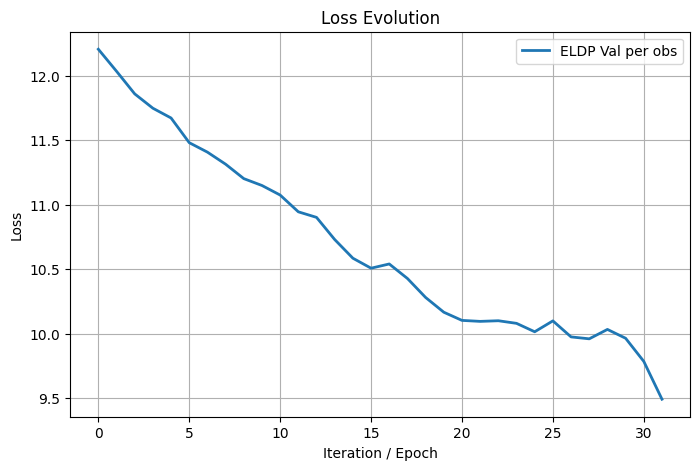

In [11]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0259
KLD GTM      Train Data:  -0.0003
KLD Gaussian Train Data:  0.0913
KLD Copula   Train Data:  -0.0009

KLD BGTM      Test  Data:  0.0352
KLD GTM      Test  Data:  0.0107
KLD Gaussian Test  Data:  0.1144
KLD Copula   Test  Data:  0.0041


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

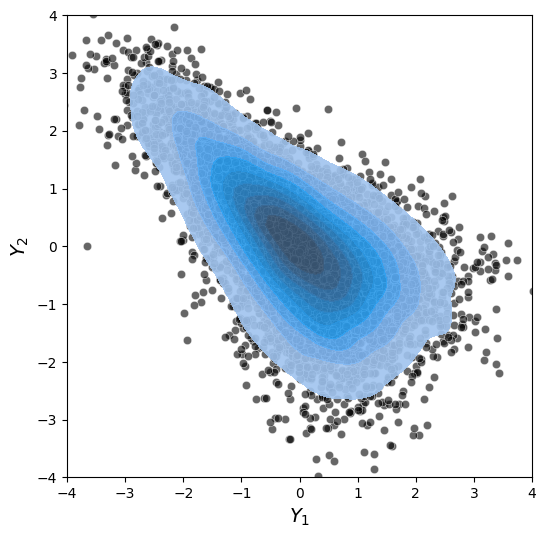

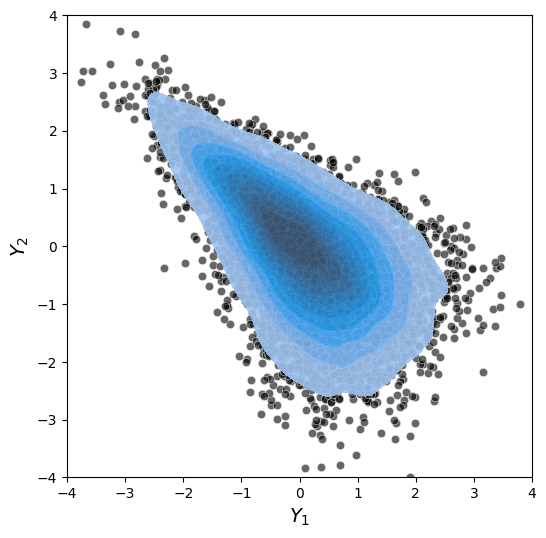

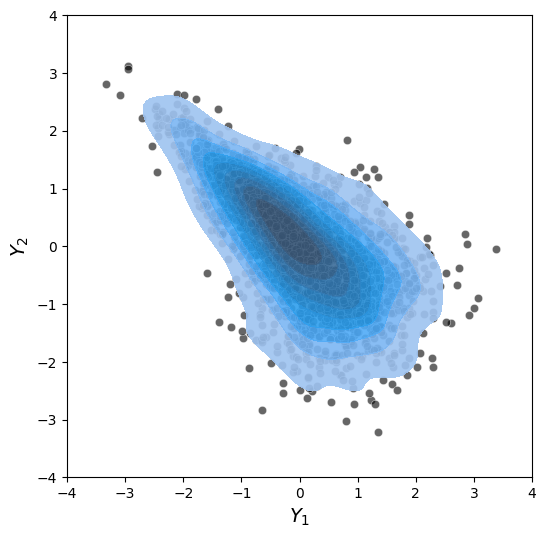

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


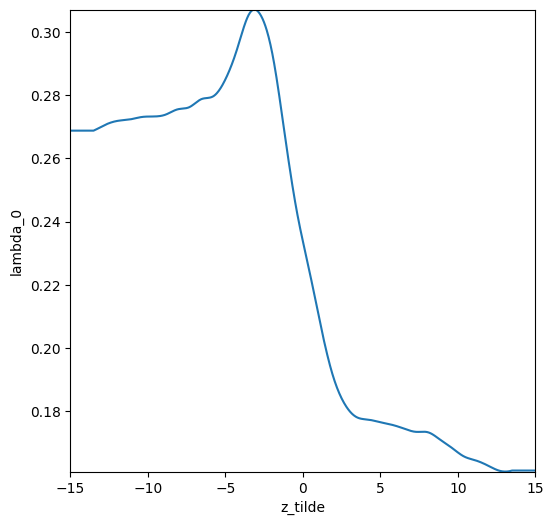

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


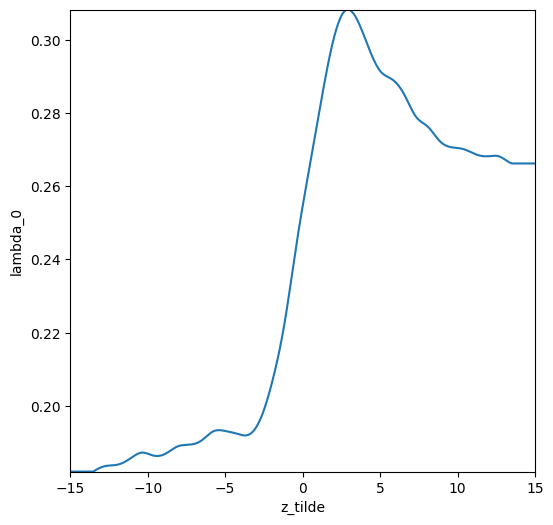

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


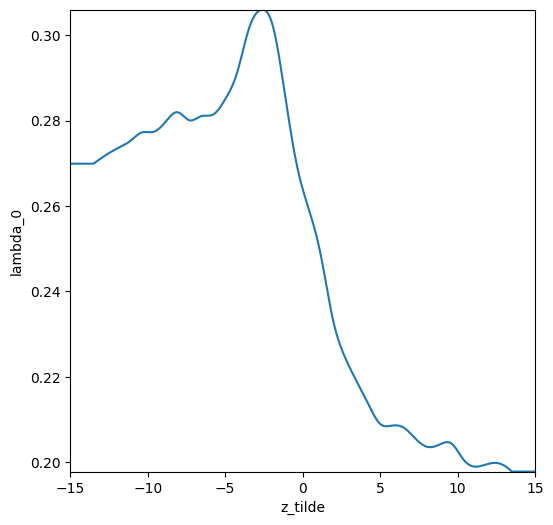

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)